#### Aquí encontrarás todo lo que necesitas saber: https://www.kaggle.com/competitions/desafio-de-prediccion-de-precios-de-portatiles

## Librerias

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import *
from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.neighbors import *
from sklearn.preprocessing import *
from xgboost import *

## Data Exploration

In [2]:
df = pd.read_csv("train_limpio.csv") #descargamos el archivo que tiene el miniEDA hecho.

In [3]:
df.head(10)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1002,Dell,Inspiron 5567,Notebook,15.6,HD,i7,8,HDD,Dedicated,Windows 10,2.36,749.00
1,867,Asus,Other,Notebook,15.6,HD,Pentium,4,HDD,Integrated,Windows 10,2.00,449.00
2,966,Toshiba,Other,Notebook,13.3,Full HD,i5,8,SSD,Integrated,Windows 7,1.20,1460.00
3,767,Dell,Alienware 17,Gaming,15.6,4K,i7,16,Hybrid,Dedicated,Windows 10,4.42,2868.99
4,1241,Dell,Other,Ultrabook,12.5,Full HD,i5,8,SSD,Integrated,Windows 7,1.26,1713.37
5,376,Asus,Other,2 in 1 Convertible,15.6,Full HD,i7,12,Hybrid,Dedicated,Windows 10,2.26,1099.00
6,60,Asus,Other,Notebook,15.6,Full HD,i3,4,SSD,Integrated,Linux,2.00,415.00
7,1157,MSI,Other,Gaming,15.6,Full HD,i7,8,Hybrid,Dedicated,Windows 10,2.40,1142.80
8,110,Asus,Other,Ultrabook,14.0,Full HD,i7,8,SSD,Dedicated,Windows 10,1.30,1193.00
9,1263,Asus,Other,Gaming,15.6,Full HD,i7,16,Hybrid,Dedicated,Windows 10,2.50,1600.00


Se trata de un problema supervisado de regresión, ya que queremos predecir un valor numérico continuo: el precio (Prices_euros).

### MiniEDA

Se ha realizado el miniEDA en otro archivo (MiniEDA.ipynb) del cual se obtiene los siguientes resultados:

Features numéricas relevantes: ['laptop_ID', 'Inches', 'Ram', 'Weight']

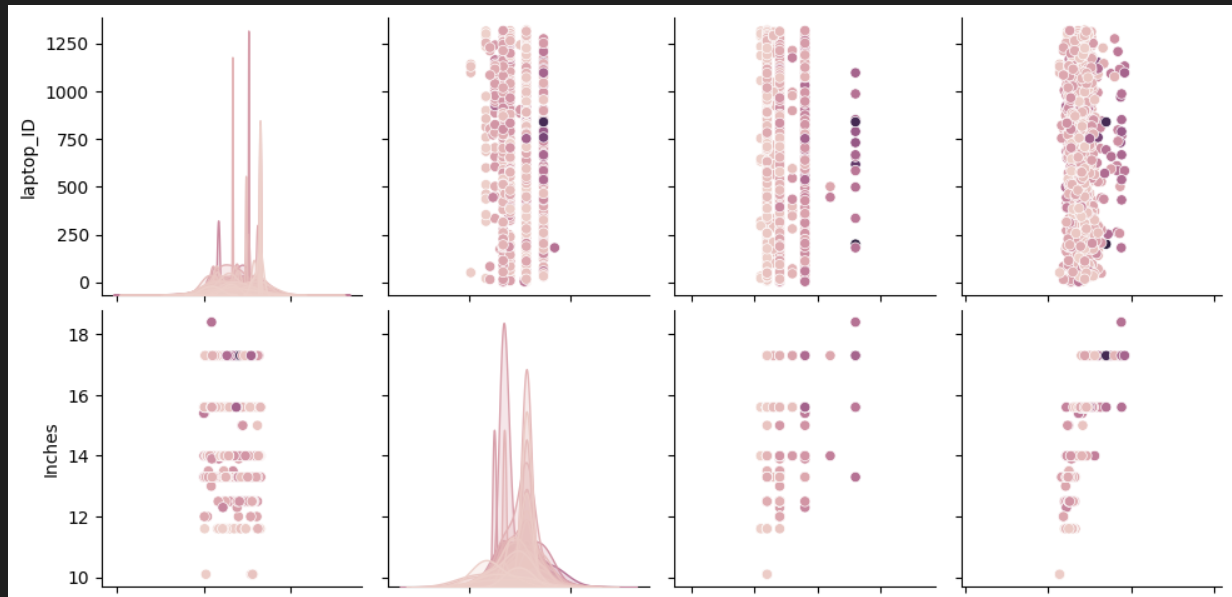

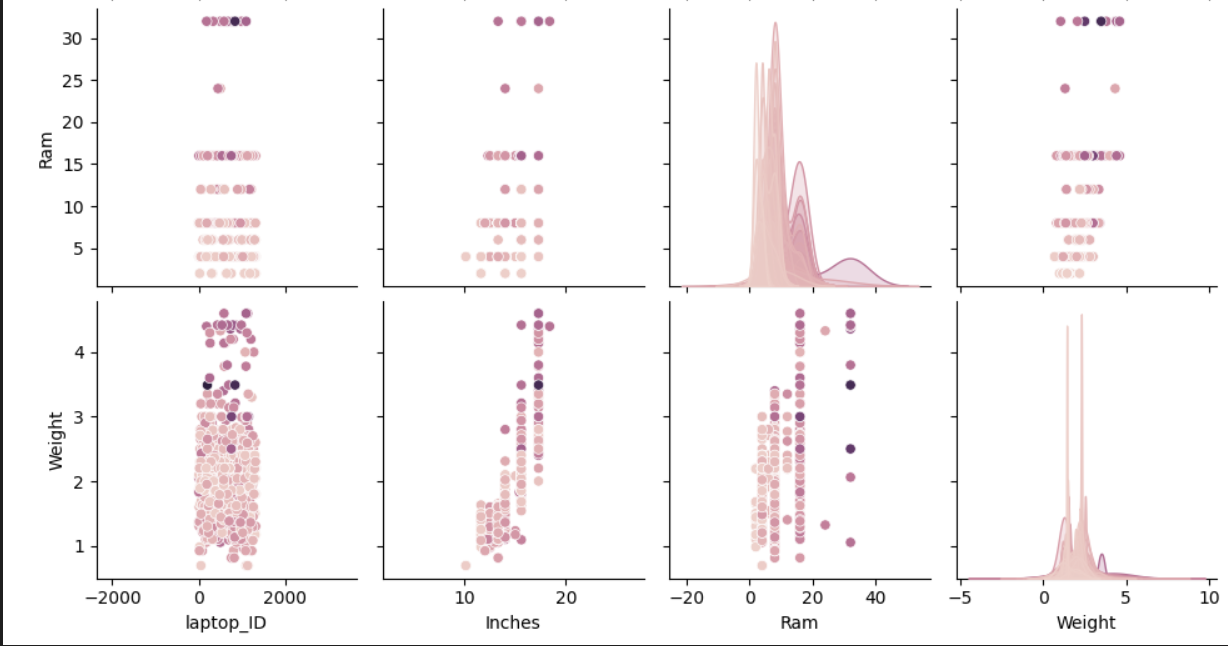

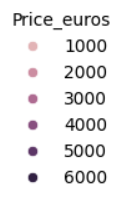

Features categóricas relevantes: ['Company', 'Product', 'TypeName', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'OpSys']

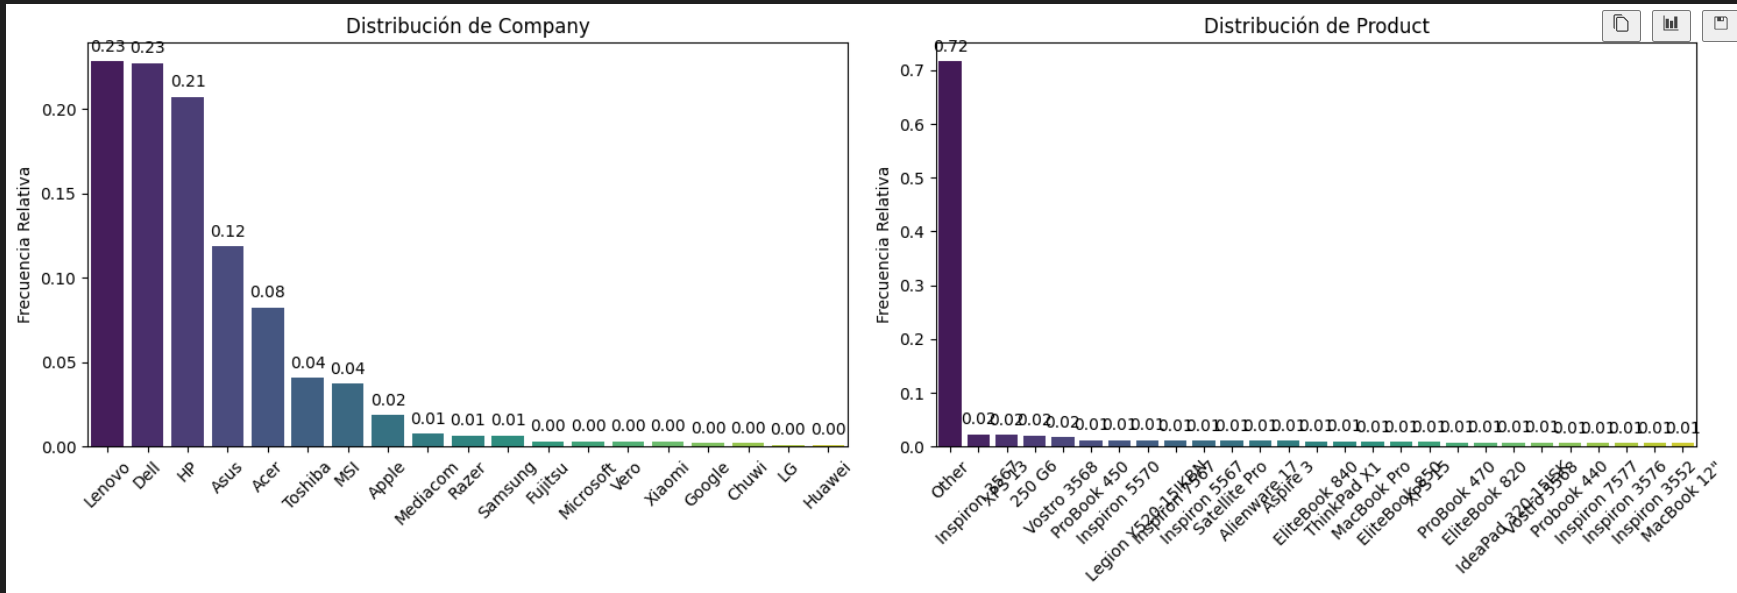

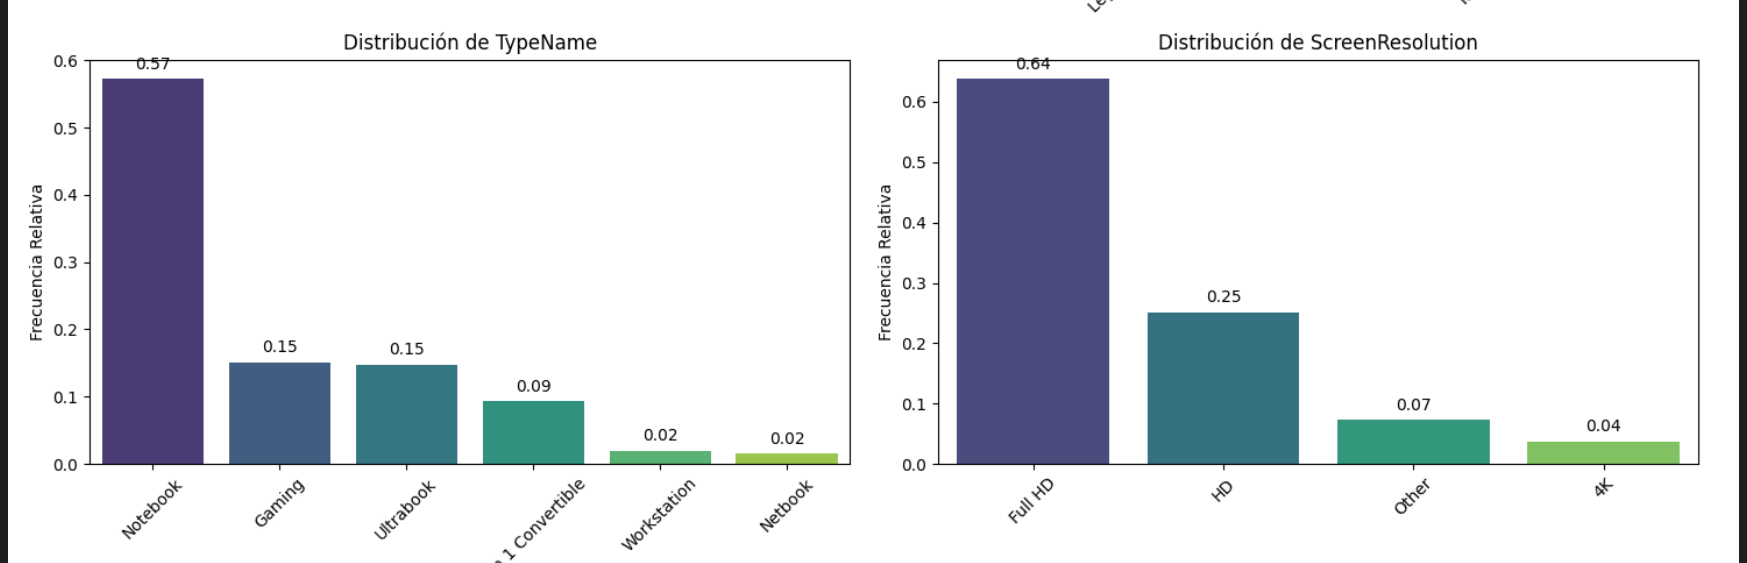

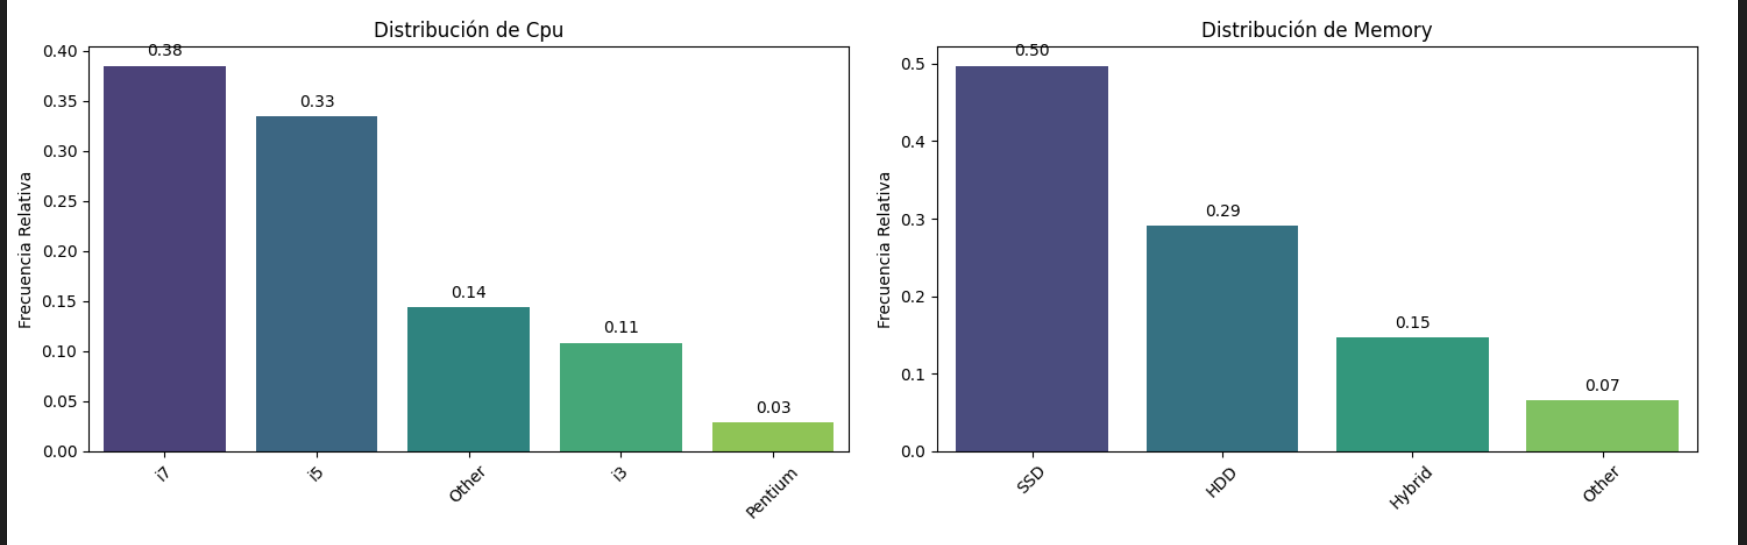

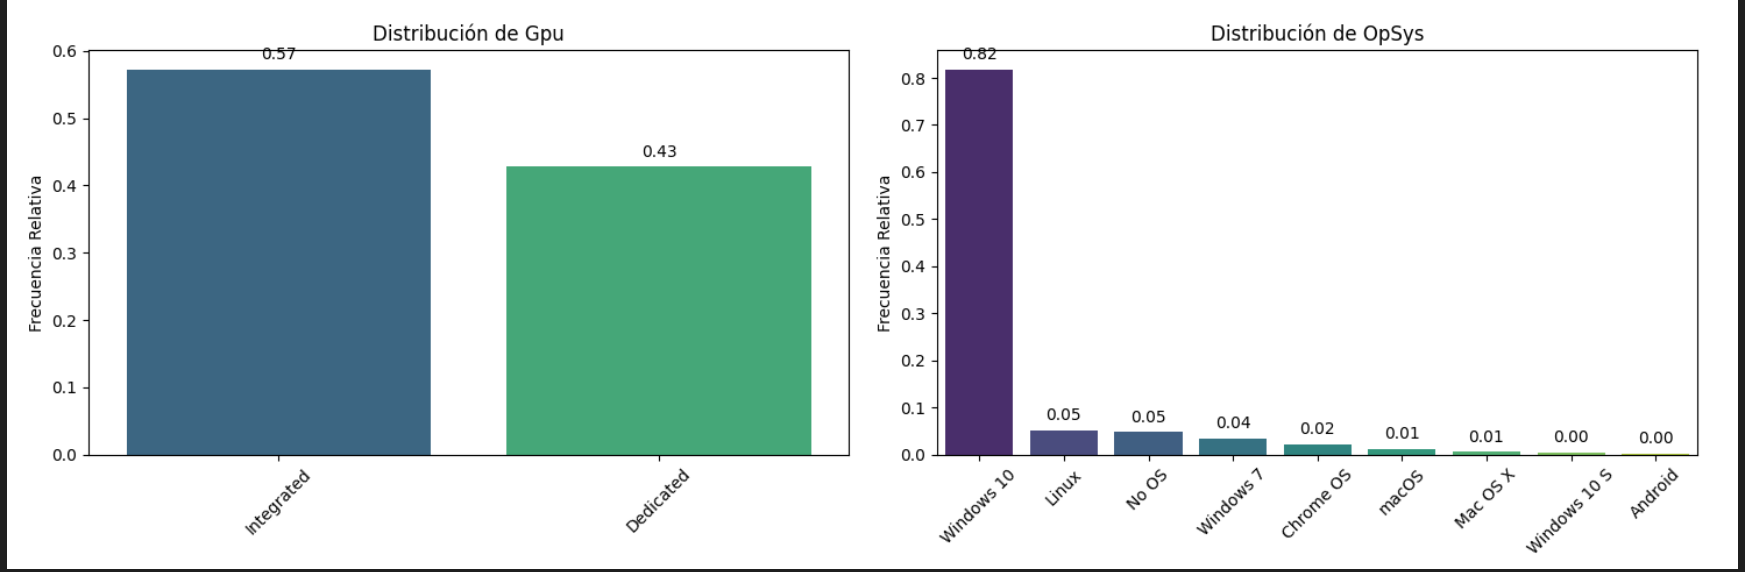

In [4]:
target = 'Price_euros'

## Pasos que si o si debéis realizar para poder participar en la competición:

Convertimos las variables categóricas usando un one-hot encoding. Podemos hacer esto porque ya hemos realizado el miniEDA y el split.

In [5]:
col_cat = df.select_dtypes(include = "object").columns.to_list()
col_cat

['Company',
 'Product',
 'TypeName',
 'ScreenResolution',
 'Cpu',
 'Memory',
 'Gpu',
 'OpSys']

In [6]:
df_encoded = pd.get_dummies(df, columns= col_cat, dtype= int)

### 1. Definir X e y

In [7]:
X = df_encoded.drop(columns=['Price_euros'])
y = df_encoded['Price_euros']

### 2. Dividir X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Crear y entrenar el modelo


In [9]:
rf_reg = RandomForestRegressor(random_state= 42)
xgb_reg = XGBRegressor(random_state = 42)

In [10]:
def regression_report(model, X, y):
    y_pred = model.predict(X)
    print("MAE:", mean_absolute_error(y, y_pred))

In [11]:
#Entrenamos los tres contra train, muestra el report de errores de cada uno contra el dataset de train utilizando la función del ejercicio anterior.
rf_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [12]:
for nombre,modelo in zip(["RandomForest","XGBoost"],[rf_reg, xgb_reg]):
    print(f"Report para {nombre}:")
    regression_report(modelo,X_train,y_train)
    print("\n\n")

Report para RandomForest:
MAE: 72.1129854595336



Report para XGBoost:
MAE: 27.494897896304867





El reporte contra train puede ser engañoso, de hecho podría haber bastante overfitting, por eso para comparar modelos empleamos de primeras la validación cruzada. Obten el RMSE medio para cada modelo usando la validación cruzada tal y como has visto en los workout y escoge un modelo. NOTA: Recuerda el "problemilla" con usar un score que es un error para sklearn

In [13]:
val_score = {}
score = "neg"
for nombre,modelo in zip(["RandomForest","XGBoost"],[rf_reg, xgb_reg]):
    print(f"Score en validación cruzada para {nombre}:")
    metricas = cross_val_score(modelo, X_train, y_train, cv = 5, scoring= "neg_mean_squared_error")
    rmse = np.sqrt(-np.mean(metricas))
    print(rmse)
    val_score[nombre] = rmse
    print("\n\n")

Score en validación cruzada para RandomForest:


316.3490288125077



Score en validación cruzada para XGBoost:
324.940954291868





In [14]:
print(f"Modelo escogido: {list(val_score.keys())[np.argmin(list(val_score.values()))]}")

Modelo escogido: RandomForest


Optimiza los hiperparámetros del modelo escogido. Escoge un grid pequeño, pero que incluya los valores por defecto (si no, no aparecerá el que ha salido mejor en la comparación por validación cruzada)

In [15]:
### Un grid básico (Que incluye valores por defecto para los hiperparámetros más significativos de RandomForest)

grid_1 = {
    'n_estimators': [100, 200],
    'max_depth': [10, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(rf_reg,
                       param_grid= grid_1,
                       cv = 5,
                       scoring= "neg_mean_squared_error")

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

Muestra los hiperparámetros escogidos y el score de ese estimador en la validación cruzada interna que habrá hecho el GridSearchCV

In [16]:
print(rf_grid.best_params_)
print(np.sqrt(-rf_grid.best_score_))

{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
315.6876421828086


### 4. Sacar métricas, valorar el modelo 

Recuerda que en la competición se va a evaluar con la métrica de MAE.

In [17]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el MAE
mae = mean_absolute_error(y_test, y_pred)

In [18]:
mae

190.7911256830601

In [19]:
#Comprobamos overfitting
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error') #hemos utilizado la métrica negativa del Error Absoluto Medio (MAE) para que los resultados sean positivos.
print("Mean MAE:", -cv_results.mean())
print("Standard deviation of MAE:", cv_results.std())

Mean MAE: 199.3797600306251
Standard deviation of MAE: 22.082388179291627


La puntuación MAE promedio obtenida en la validación cruzada (199.38) es ligeramente mayor que el MAE calculado en el conjunto de prueba (190.79). No es una gran diferencia pero podría haber overfitting. De modo podemos evitar la regularización L1 (Lasso) o L2 (Ridge).

La desviación estándar de MAE en la validación cruzada es de aproximadamente 22.08. Es un modelo estable.

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir con el dataset de predicción 

Definición de **modelo que está listo**. 

Tras hacer suficientes pruebas, analizar los datos, hacer feature engineering, probar diferentes modelos con diferentes parámetros, es con este con el que observo mejores métricas y menos overfitting. ¡Cuidado con el overfitting aquí! Si vuestro modelo aprende muy bien de estos datos pero hay overfitting cuando le pasemos los datos desconocidos de `test.csv` nos arriesgamos a que digamos, no salga lo esperado.

### 1. Entrena dicho modelo con TODOS tus datos de train, esto es con `train.csv` al completo.


**CON LAS TRANSFORMACIONES QUE LE HAYAS REALIZADO A `X` INCLUÍDAS.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 2. Carga los datos de `test.csv` para predecir.

In [43]:
df_test = pd.read_csv("test_limpio.csv") #descargamos el archivo que tiene el miniEDA hecho.
df_test

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,1098,HP,Other,Ultrabook,13.3,4K,i7,16,SSD,Integrated,Windows 10,1.30
1,330,Acer,Other,Notebook,15.6,HD,Other,8,SSD,Dedicated,Windows 10,2.20
2,1260,Acer,Other,Notebook,15.6,HD,i3,4,HDD,Integrated,Linux,2.40
3,1137,HP,Other,Notebook,14.0,Full HD,i5,8,SSD,Integrated,Windows 7,1.43
4,1015,HP,Other,Notebook,13.3,Full HD,i5,8,SSD,Integrated,Windows 10,1.34
...,...,...,...,...,...,...,...,...,...,...,...,...
386,145,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD,i7,8,SSD,Dedicated,No OS,2.40
387,1195,Lenovo,Other,Gaming,15.6,Full HD,i7,16,SSD,Dedicated,Windows 10,3.31
388,1070,HP,Other,Notebook,15.6,HD,i5,4,HDD,Integrated,No OS,1.96
389,104,HP,Other,Notebook,15.6,Full HD,Other,4,HDD,Dedicated,Windows 10,2.10


In [44]:
df_encoded_test = pd.get_dummies(df_test, columns= col_cat, dtype= int)

In [45]:
df_encoded_test

,laptop_ID,Inches,Ram,Weight,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Google,...,Gpu_Dedicated,Gpu_Integrated,OpSys_Chrome OS,OpSys_Linux,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS
0,1098,13.3,16,1.30,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,330,15.6,8,2.20,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,1260,15.6,4,2.40,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,1137,14.0,8,1.43,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,1015,13.3,8,1.34,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,145,15.6,8,2.40,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
387,1195,15.6,16,3.31,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
388,1070,15.6,4,1.96,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
389,104,15.6,4,2.10,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [46]:
df_encoded

,laptop_ID,Inches,Ram,Weight,Price_euros,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,...,Gpu_Integrated,OpSys_Android,OpSys_Chrome OS,OpSys_Linux,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS
0,1002,15.6,8,2.36,749.00,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,867,15.6,4,2.00,449.00,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
2,966,13.3,8,1.20,1460.00,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,767,15.6,16,4.42,2868.99,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1241,12.5,8,1.26,1713.37,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,973,11.6,4,1.25,389.00,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
908,1018,13.3,4,1.20,1195.00,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
909,1071,15.6,8,2.40,449.00,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
910,965,14.0,8,1.36,1775.00,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


**¿Por qué puede dar error?** 

IMPORTANTE: APLICAR A ESTOS DATOS LO MISMO QUE HAYÁIS APLICADO A LOS DATOS DE ENTRENAMIENTO

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO BORRAR FILAS, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER 391 FILAS, SI O SI

**Entonces, si al cargar los datos de train usé `index_col=0` para que utilizara la primera columna del conjunto de datos como índice, ¿tendré que hacerlo también para el conjunto `test.csv`?**

In [ ]:
# ¿Qué opináis?
#Sí, el test.csv también tiene esa misma columna

![](https://www.tierraljelechu.com/web/img/wiki_up/1.996-SorpresaDto.-1-Red.jpg)

### 3. AHORA puedo hacer la predicción que será lo que subirás a Kaggle. 

**¿Qué es lo que subirás a Kaggle?**

In [51]:
X_train

,laptop_ID,Inches,Ram,Weight,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,...,Gpu_Integrated,OpSys_Android,OpSys_Chrome OS,OpSys_Linux,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS
25,41,15.6,4,2.00,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
84,127,15.6,4,2.10,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10,1243,15.6,4,2.65,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
342,105,15.6,8,2.20,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
890,578,14.0,8,1.94,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,267,15.6,4,2.10,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
270,610,17.3,16,4.14,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
860,1026,14.0,4,1.48,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
435,363,15.6,8,2.65,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [52]:
df_encoded_test

,laptop_ID,Inches,Ram,Weight,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Google,...,Gpu_Dedicated,Gpu_Integrated,OpSys_Chrome OS,OpSys_Linux,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS
0,1098,13.3,16,1.30,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,330,15.6,8,2.20,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,1260,15.6,4,2.40,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,1137,14.0,8,1.43,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,1015,13.3,8,1.34,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,145,15.6,8,2.40,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
387,1195,15.6,16,3.31,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
388,1070,15.6,4,1.96,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
389,104,15.6,4,2.10,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [54]:
# Nos aseguramos de que X_test tiene las mismas columnas que X_train
X_test = df_encoded_test.reindex(columns=X_train.columns, fill_value=0)
X_test

,laptop_ID,Inches,Ram,Weight,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,...,Gpu_Integrated,OpSys_Android,OpSys_Chrome OS,OpSys_Linux,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS
0,1098,13.3,16,1.30,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,330,15.6,8,2.20,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1260,15.6,4,2.40,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
3,1137,14.0,8,1.43,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1015,13.3,8,1.34,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,145,15.6,8,2.40,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
387,1195,15.6,16,3.31,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
388,1070,15.6,4,1.96,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
389,104,15.6,4,2.10,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [55]:
predictions = model.predict(X_test)
predictions

array([1906.3946,  715.8656,  422.7047, 1394.68  , 1328.8484, 2066.5077,
       2832.1296,  699.905 , 3080.2216, 1615.0607, 1389.4625,  731.6703,
        283.0937,  661.8095,  456.0025, 1619.2509,  603.7894, 1556.4094,
       1353.5117, 1629.9637, 1580.6296, 1203.46  , 1734.9529, 1434.4011,
       1802.6478,  443.5823,  982.5512,  412.5069, 1420.07  ,  524.3958,
       1176.831 , 1260.4627, 1997.8709,  499.7611,  737.644 , 1724.4272,
        851.1949,  643.6383, 2955.1155,  507.6649,  688.4529, 1021.2171,
       1310.589 , 1805.6525,  960.691 , 1549.563 ,  496.6791, 2812.9589,
        305.0325, 1462.2068, 1174.3519,  939.2169, 1040.9362,  359.2296,
       1450.6903,  726.7501, 1134.3236,  256.26  , 1262.1575, 1157.3536,
       1552.9362, 1066.6466,  606.9704, 1375.9399, 1275.5514,  948.196 ,
        672.1751, 2593.1874,  586.5418, 1994.4356,  881.9602, 2801.5167,
       2091.6147,  818.8127, 1250.114 , 1016.1872, 1180.2945,  455.8588,
       1201.7413, 1047.1797,  292.449 , 2095.4371, 

**¡PERO! Para subir a Kaggle la predicción, ésta tendrá que tener una forma específica y no valdrá otra.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [24]:
sample = pd.read_csv("sample_submission.csv") # Esta es mi ruta del archivo, la vuestra puede ser otra

In [25]:
sample.head()

,id,Price_euros
0,1014,752.0
1,845,499.0
2,1151,1747.0
3,1265,245.0
4,573,1179.0


In [26]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe. 

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [56]:
df_predictor = pd.DataFrame(predictions, columns=['Price_euros'])
df_predictor

,Price_euros
0,1906.3946
1,715.8656
2,422.7047
3,1394.6800
4,1328.8484
...,...
386,914.1927
387,2284.7431
388,607.0442
389,424.6772


In [57]:
df_predictor['id'] = range(0, len(df_predictor))
df_predictor

,Price_euros,id
0,1906.3946,0
1,715.8656,1
2,422.7047,2
3,1394.6800,3
4,1328.8484,4
...,...,...
386,914.1927,386
387,2284.7431,387
388,607.0442,388
389,424.6772,389


In [58]:
df_predictor = df_predictor[['id', 'Price_euros']]

In [59]:
df_predictor

,id,Price_euros
0,0,1906.3946
1,1,715.8656
2,2,422.7047
3,3,1394.6800
4,4,1328.8484
...,...,...
386,386,914.1927
387,387,2284.7431
388,388,607.0442
389,389,424.6772


In [60]:
df_predictor = sample.merge(sample[['id']], on='id')
df_predictor

,id,Price_euros
0,1014,752.0
1,845,499.0
2,1151,1747.0
3,1265,245.0
4,573,1179.0
...,...,...
386,1162,258.0
387,1286,1085.0
388,336,298.0
389,885,1099.0


### 5. Pásale el CHEQUEATOR para comprobar que efectivamente está listo para subir a Kaggle.

In [32]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                df_predictor.to_csv("submission.csv", index = False) #muy importante el index = False
                #urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("")


In [61]:
chequeator(df_predictor) # submission es el nombre que le habríamos puesto a nuestro .csv con los valores que me salieron en la predicción

You're ready to submit!


NameError: name 'urllib' is not defined